# Interactive Exploration: Gaussian Bayesian Updates and Mixture Models

This notebook provides interactive visualizations to explore:
1. **Gaussian-Gaussian Bayesian Updates**: How variance and number of observations affect learning
2. **Gaussian Mixture Models**: How priors and variance affect categorization

All implementations use **GenJAX** for probabilistic programming.

---

## 📚 Building on Previous Concepts

This notebook combines several key concepts you've learned:

**From Tutorial 1 (Discrete Probability):**
- **[Chapter 4 - Conditional Probability](../../content/intro/04_conditional.md)**: We'll use conditional probability P(μ|data) extensively
- **[Chapter 5 - Bayes' Theorem](../../content/intro/05_bayes.md)**: The foundation of Bayesian learning!

**From Tutorial 2 (Continuous Probability):**
- **[Chapter 1 - Expected Value & Mixtures](../../content/intro2/01_mystery_bentos.md)**: Mixture models extend the bento mixture idea
- **[Chapter 2 - Continuous Distributions](../../content/intro2/02_continuous.md)**: PDFs and continuous probability
- **[Chapter 3 - Gaussian Distribution](../../content/intro2/03_gaussian.md)**: The bell curve we're updating!
- **[Chapter 4 - Bayesian Learning](../../content/intro2/04_bayesian_learning.md)**: The conjugate prior framework

**New in this assignment:**
- Systematic exploration of **how parameters affect learning**
- Understanding **precision-weighted averaging** intuitively
- Connecting **categorization** to Bayes' rule in continuous setting

In [1]:
# Import packages
import jax
import jax.numpy as jnp
import jax.random as random
import jax.lax as lax
from genjax import gen, bernoulli, normal
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm as scipy_norm
from ipywidgets import interact, FloatSlider, IntSlider, fixed
import ipywidgets as widgets

# Set random seed for reproducibility
key = random.PRNGKey(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Part 1: Gaussian-Gaussian Bayesian Update

### The Model

**Prior**: $\mu \sim \mathcal{N}(\mu_0, \sigma_0^2)$

**Likelihood**: $x_1, \ldots, x_N | \mu, \sigma_x^2 \overset{iid}{\sim} \mathcal{N}(\mu, \sigma_x^2)$

**Posterior**: $\mu | x_1, \ldots, x_N \sim \mathcal{N}(\mu_N, \sigma_N^2)$

where:

$$\mu_N = \frac{\mu_0 \sigma_0^{-2} + \sigma_x^{-2} \sum_{n=1}^N x_n}{\sigma_0^{-2} + N \sigma_x^{-2}}$$

$$\sigma_N^2 = \left[ \sigma_0^{-2} + N \sigma_x^{-2} \right]^{-1}$$

**Predictive**: $x_{N+1} | x_1, \ldots, x_N \sim \mathcal{N}(\mu_N, \sigma_N^2 + \sigma_x^2)$

---

### 📖 Connection to Bayes' Theorem

Remember **[Bayes' Theorem from Tutorial 1, Chapter 5](../../content/intro/05_bayes.md)**:

$$P(H|E) = \frac{P(E|H) \cdot P(H)}{P(E)}$$

Here we're applying the same principle, but with **continuous distributions**:

$$p(\mu | x_1, \ldots, x_N) = \frac{p(x_1, \ldots, x_N | \mu) \cdot p(\mu)}{p(x_1, \ldots, x_N)}$$

Where:
- **Posterior** $p(\mu|data)$ ← what we believe about μ after seeing data
- **Likelihood** $p(data|\mu)$ ← how likely the data is for each value of μ
- **Prior** $p(\mu)$ ← what we believed about μ before seeing data
- **Evidence** $p(data)$ ← normalizing constant (total probability of data)

**The magic of conjugacy:** Because both prior and likelihood are Gaussian, the posterior is also Gaussian! This allows closed-form solutions instead of numerical approximation.

In [2]:
# Analytical Bayesian update function
def gaussian_gaussian_update(mu_0, sigma_0_sq, observations, sigma_x_sq):
    """
    Analytical Bayesian update for Gaussian-Gaussian conjugate prior.
    
    Args:
        mu_0: Prior mean
        sigma_0_sq: Prior variance
        observations: Array of observations
        sigma_x_sq: Likelihood variance (known)
    
    Returns:
        posterior_mu: Posterior mean
        posterior_sigma_sq: Posterior variance
    """
    N = len(observations)
    sum_x = jnp.sum(jnp.array(observations))
    
    # Precision-weighted update
    prior_precision = 1.0 / sigma_0_sq
    data_precision = N / sigma_x_sq
    
    posterior_precision = prior_precision + data_precision
    posterior_sigma_sq = 1.0 / posterior_precision
    
    posterior_mu = posterior_sigma_sq * (prior_precision * mu_0 + (sum_x / sigma_x_sq))
    
    return posterior_mu, posterior_sigma_sq

In [3]:
# GenJAX model for Gaussian-Gaussian learning
@gen
def gaussian_learning_model(observations, sigma_x_sq):
    """
    Generative model for Gaussian learning with unknown mean.
    
    Args:
        observations: Observed data points
        sigma_x_sq: Known likelihood variance
    """
    # Prior on unknown mean
    mu = normal(0.0, 1.0) @ "mu"
    
    # Generate observations
    sigma_x = jnp.sqrt(sigma_x_sq)
    for i in range(len(observations)):
        x = normal(mu, sigma_x) @ f"obs_{i}"
    
    return mu

@gen
def posterior_predictive_model(posterior_mu, posterior_sigma_sq, sigma_x_sq):
    """
    Sample from posterior predictive distribution.
    
    Args:
        posterior_mu: Posterior mean for mu
        posterior_sigma_sq: Posterior variance for mu
        sigma_x_sq: Likelihood variance
    """
    # Sample mu from posterior
    mu = normal(posterior_mu, jnp.sqrt(posterior_sigma_sq)) @ "mu"
    
    # Sample new observation given mu
    x_new = normal(mu, jnp.sqrt(sigma_x_sq)) @ "x_new"
    
    return x_new

### Interactive Visualization: Effect of Likelihood Variance

Explore how changing the **likelihood variance** ($\sigma_x^2$) affects the posterior and predictive distributions.

**Question**: What happens when the likelihood has:
- **Small variance** (precise measurements)?
- **Large variance** (noisy measurements)?

In [ ]:
def plot_variance_effect(sigma_x_sq, n_obs=1, x_obs=2.0):
    """
    Interactive plot showing effect of likelihood variance.
    """
    # Prior parameters (fixed)
    mu_0 = 0.0
    sigma_0_sq = 1.0
    
    # Generate observations (all at x_obs for simplicity)
    observations = [x_obs] * n_obs
    
    # Analytical update
    post_mu, post_sigma_sq = gaussian_gaussian_update(mu_0, sigma_0_sq, observations, sigma_x_sq)
    
    # Predictive parameters
    pred_mu = post_mu
    pred_sigma_sq = post_sigma_sq + sigma_x_sq
    
    # Plot range
    x_range = np.linspace(-5, 8, 1000)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Prior PDF
    prior_pdf = scipy_norm.pdf(x_range, mu_0, np.sqrt(sigma_0_sq))
    
    # Posterior PDF
    post_pdf = scipy_norm.pdf(x_range, post_mu, np.sqrt(post_sigma_sq))
    
    # Predictive PDF
    pred_pdf = scipy_norm.pdf(x_range, pred_mu, np.sqrt(pred_sigma_sq))
    
    # Plot 1: Prior vs Posterior
    axes[0].plot(x_range, prior_pdf, 'k--', linewidth=2, label=f'Prior: N({mu_0}, {sigma_0_sq})', alpha=0.7)
    axes[0].plot(x_range, post_pdf, 'b-', linewidth=2, label=f'Posterior: N({post_mu:.2f}, {post_sigma_sq:.2f})')
    axes[0].axvline(x_obs, color='red', linestyle=':', linewidth=2, label=f'Observation(s): {x_obs}')
    axes[0].axvline(post_mu, color='blue', linestyle='--', linewidth=1, alpha=0.5)
    axes[0].set_xlabel('μ', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title(f'Posterior Distribution (σ²_x = {sigma_x_sq})', fontsize=13)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Posterior vs Predictive
    axes[1].plot(x_range, post_pdf, 'b-', linewidth=2, label=f'Posterior: N({post_mu:.2f}, {post_sigma_sq:.2f})', alpha=0.7)
    axes[1].plot(x_range, pred_pdf, 'orange', linewidth=2, label=f'Predictive: N({pred_mu:.2f}, {pred_sigma_sq:.2f})')
    axes[1].axvline(post_mu, color='blue', linestyle='--', linewidth=1, alpha=0.5)
    axes[1].set_xlabel('x', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title(f'Predictive Distribution (σ²_x = {sigma_x_sq})', fontsize=13)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print(f"\n📊 Interpretation:")
    print(f"  Prior mean: {mu_0:.2f}, Prior std: {np.sqrt(sigma_0_sq):.2f}")
    print(f"  Observation(s): {x_obs:.2f} (n={n_obs})")
    print(f"  Likelihood std: {np.sqrt(sigma_x_sq):.2f}")
    print(f"  Posterior mean: {post_mu:.2f} (shifted toward data)")
    print(f"  Posterior std: {np.sqrt(post_sigma_sq):.2f} (uncertainty decreased)")
    print(f"  Predictive std: {np.sqrt(pred_sigma_sq):.2f} (larger due to data variance)")

# Create interactive widget
interact(plot_variance_effect,
         sigma_x_sq=FloatSlider(min=0.1, max=5.0, step=0.1, value=0.25, description='σ²_x (likelihood var)'),
         n_obs=IntSlider(min=1, max=10, step=1, value=1, description='Num observations'),
         x_obs=FloatSlider(min=-2.0, max=4.0, step=0.5, value=2.0, description='Observation value'));

interactive(children=(FloatSlider(value=0.25, description='σ²_x (likelihood var)', max=5.0, min=0.1), IntSlide…

### Interactive Visualization: Sequential Learning

Watch how the posterior evolves as we add more observations!

In [ ]:
def plot_sequential_learning(n_observations, sigma_x_sq=0.25):
    """
    Show sequential Bayesian updates.
    """
    # Fixed parameters
    mu_0 = 0.0
    sigma_0_sq = 1.0
    
    # Generate observations around x=2
    np.random.seed(42)
    observations = [2.1, 2.5, 1.4, 2.2, 1.8, 2.0, 1.9, 2.3, 1.7, 2.1]
    observations = observations[:n_observations]
    
    # Plot range
    x_range = np.linspace(-3, 5, 1000)
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Plot prior
    prior_pdf = scipy_norm.pdf(x_range, mu_0, np.sqrt(sigma_0_sq))
    ax.plot(x_range, prior_pdf, 'k--', linewidth=2, label='Prior: N(0, 1)', alpha=0.7)
    
    # Sequential updates
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, min(n_observations, 5)))
    
    mu_current = mu_0
    sigma_sq_current = sigma_0_sq
    
    # Show specific steps
    steps_to_show = [1, 3, 5, n_observations] if n_observations > 5 else list(range(1, n_observations + 1))
    steps_to_show = sorted(set(steps_to_show))
    
    for i in range(n_observations):
        mu_current, sigma_sq_current = gaussian_gaussian_update(
            mu_current, sigma_sq_current, [observations[i]], sigma_x_sq
        )
        
        if (i + 1) in steps_to_show:
            post_pdf = scipy_norm.pdf(x_range, mu_current, np.sqrt(sigma_sq_current))
            color_idx = min(steps_to_show.index(i + 1), len(colors) - 1)
            ax.plot(x_range, post_pdf, linewidth=2, 
                   label=f'After {i+1} obs: N({mu_current:.2f}, {sigma_sq_current:.2f})',
                   color=colors[color_idx] if n_observations > 1 else 'blue')
    
    # Mark sample mean
    sample_mean = np.mean(observations)
    ax.axvline(sample_mean, color='red', linestyle=':', linewidth=2, 
              label=f'Sample mean: {sample_mean:.2f}')
    
    ax.set_xlabel('μ', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'Sequential Bayesian Learning (σ²_x = {sigma_x_sq})', fontsize=13)
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n📊 Summary after {n_observations} observations:")
    print(f"  Observations: {observations}")
    print(f"  Sample mean: {sample_mean:.2f}")
    print(f"  Final posterior: N({mu_current:.2f}, {sigma_sq_current:.2f})")
    print(f"  Posterior std: {np.sqrt(sigma_sq_current):.2f} (uncertainty: {np.sqrt(sigma_0_sq):.2f} → {np.sqrt(sigma_sq_current):.2f})")

# Create interactive widget
interact(plot_sequential_learning,
         n_observations=IntSlider(min=1, max=10, step=1, value=1, description='Num observations'),
         sigma_x_sq=FloatSlider(min=0.1, max=2.0, step=0.1, value=0.25, description='σ²_x'));

interactive(children=(IntSlider(value=1, description='Num observations', max=10, min=1), FloatSlider(value=0.2…

## Part 2: Gaussian Mixture - Two Clusters

### The Model

**Generative Process**:

$$c_n | \theta \sim \text{Bernoulli}(\theta)$$
$$x_n | \mu_{c(n)}, \sigma_{c(n)}^2 \sim \mathcal{N}(\mu_{c(n)}, \sigma_{c(n)}^2)$$

**Posterior Probability of Category 1**:

$$P(c=1|x) = \frac{\theta \, \mathcal{N}(x; \mu_1, \sigma_1^2)}{\theta \, \mathcal{N}(x; \mu_1, \sigma_1^2) + (1-\theta) \, \mathcal{N}(x; \mu_2, \sigma_2^2)}$$

**Marginal Distribution** (Predictive):

$$p(x) = \theta \, \mathcal{N}(x; \mu_1, \sigma_1^2) + (1-\theta) \, \mathcal{N}(x; \mu_2, \sigma_2^2)$$

---

### 📖 Connection to Previous Concepts

**From [Tutorial 2, Chapter 1 - Mystery Bentos](../../content/intro2/01_mystery_bentos.md)**:

Remember Chibany's discrete mixture of tonkatsu (70%) vs hamburger (30%) bentos? That was:
$$E[X] = 0.7 \times 500g + 0.3 \times 350g = 455g$$

**Now we're extending that idea with Gaussian distributions:**
- Instead of exact weights (500g, 350g), each category has a **distribution** N(μ, σ²)
- The **marginal** p(x) is still a weighted mixture, but now of continuous distributions
- This creates the realistic **within-category variation** we see in real data!

**From [Tutorial 1, Chapter 4 - Conditional Probability](../../content/intro/04_conditional.md)**:

The posterior probability P(c=1|x) uses **Bayes' rule**:
$$P(c|x) = \frac{P(x|c) \cdot P(c)}{P(x)} = \frac{\text{Likelihood} \times \text{Prior}}{\text{Marginal}}$$

Where:
- **Prior**: P(c=1) = θ (what we believe before seeing x)
- **Likelihood**: P(x|c=1) = N(x; μ₁, σ₁²) (how likely is x if it's category 1?)
- **Marginal**: P(x) = sum over all categories (total probability of observing x)
- **Posterior**: P(c=1|x) (updated belief after seeing x)

**Key insight:** This is the **continuous version** of the weighted counting you learned in Tutorial 1!

In [6]:
def compute_categorization(x_range, mu_1, mu_2, sigma_1_sq, sigma_2_sq, theta):
    """
    Compute posterior probability of category 1 and marginal distribution.
    
    Args:
        x_range: Range of x values
        mu_1, mu_2: Means of categories 1 and 2
        sigma_1_sq, sigma_2_sq: Variances of categories 1 and 2
        theta: Prior probability of category 1
    
    Returns:
        posterior_c1: P(c=1|x)
        marginal: p(x)
        likelihood_1: p(x|c=1)
        likelihood_2: p(x|c=2)
    """
    # Likelihoods
    likelihood_1 = scipy_norm.pdf(x_range, mu_1, np.sqrt(sigma_1_sq))
    likelihood_2 = scipy_norm.pdf(x_range, mu_2, np.sqrt(sigma_2_sq))
    
    # Marginal distribution
    marginal = theta * likelihood_1 + (1 - theta) * likelihood_2
    
    # Posterior probability of category 1
    posterior_c1 = (theta * likelihood_1) / marginal
    
    return posterior_c1, marginal, likelihood_1, likelihood_2

### Interactive Visualization: Effect of Prior (θ) on Categorization

In [7]:
def plot_categorization(theta, sigma_1_sq=1.0, sigma_2_sq=1.0):
    """
    Interactive plot of categorization decisions.
    """
    # Fixed means
    mu_1 = -1.0
    mu_2 = 1.0
    
    # x range
    x_range = np.linspace(-6, 6, 1000)
    
    # Compute probabilities
    post_c1, marginal, lik_1, lik_2 = compute_categorization(
        x_range, mu_1, mu_2, sigma_1_sq, sigma_2_sq, theta
    )
    
    # Create figure
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Likelihoods
    axes[0].plot(x_range, lik_1, 'b-', linewidth=2, 
                label=f'Likelihood c=1: N({mu_1}, {sigma_1_sq})', alpha=0.7)
    axes[0].plot(x_range, lik_2, 'r-', linewidth=2, 
                label=f'Likelihood c=2: N({mu_2}, {sigma_2_sq})', alpha=0.7)
    axes[0].axvline(mu_1, color='blue', linestyle='--', linewidth=1, alpha=0.5)
    axes[0].axvline(mu_2, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[0].set_xlabel('x', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title('Likelihood Distributions', fontsize=13)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Posterior probability of c=1
    axes[1].plot(x_range, post_c1, 'purple', linewidth=2, 
                label=f'P(c=1|x), θ={theta}')
    axes[1].axhline(0.5, color='black', linestyle=':', linewidth=1, alpha=0.5, label='Decision boundary')
    axes[1].fill_between(x_range, 0, post_c1, alpha=0.3, color='blue', label='Classify as c=1')
    axes[1].fill_between(x_range, post_c1, 1, alpha=0.3, color='red', label='Classify as c=2')
    
    # Find decision boundary (where P(c=1|x) = 0.5)
    decision_idx = np.argmin(np.abs(post_c1 - 0.5))
    decision_x = x_range[decision_idx]
    axes[1].axvline(decision_x, color='green', linestyle='--', linewidth=2, 
                   label=f'Decision boundary: x={decision_x:.2f}')
    
    axes[1].set_xlabel('x', fontsize=12)
    axes[1].set_ylabel('P(c=1|x)', fontsize=12)
    axes[1].set_title(f'Posterior Probability of Category 1 (θ={theta})', fontsize=13)
    axes[1].set_ylim([-0.05, 1.05])
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print(f"\n📊 Interpretation:")
    print(f"  Prior P(c=1) = {theta:.2f}")
    print(f"  Decision boundary at x = {decision_x:.2f}")
    print(f"  Variance ratio σ²_1/σ²_2 = {sigma_1_sq/sigma_2_sq:.2f}")
    if theta > 0.5:
        print(f"  → Prior favors c=1, so decision boundary shifts toward c=2")
    elif theta < 0.5:
        print(f"  → Prior favors c=2, so decision boundary shifts toward c=1")
    else:
        print(f"  → Equal prior, decision boundary at midpoint (if equal variances)")

# Create interactive widget
interact(plot_categorization,
         theta=FloatSlider(min=0.1, max=0.9, step=0.05, value=0.5, description='θ (prior P(c=1))'),
         sigma_1_sq=FloatSlider(min=0.25, max=3.0, step=0.25, value=1.0, description='σ²_1'),
         sigma_2_sq=FloatSlider(min=0.25, max=3.0, step=0.25, value=1.0, description='σ²_2'));

interactive(children=(FloatSlider(value=0.5, description='θ (prior P(c=1))', max=0.9, min=0.1, step=0.05), Flo…

### Interactive Visualization: Marginal Distribution (Mixture)

In [8]:
def plot_marginal_distribution(theta, sigma_1_sq=1.0, sigma_2_sq=1.0):
    """
    Interactive plot of marginal distribution (mixture).
    """
    # Fixed means
    mu_1 = -1.0
    mu_2 = 1.0
    
    # x range
    x_range = np.linspace(-6, 6, 1000)
    
    # Compute probabilities
    post_c1, marginal, lik_1, lik_2 = compute_categorization(
        x_range, mu_1, mu_2, sigma_1_sq, sigma_2_sq, theta
    )
    
    # Weighted components
    weighted_1 = theta * lik_1
    weighted_2 = (1 - theta) * lik_2
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Plot components
    ax.plot(x_range, weighted_1, 'b--', linewidth=2, alpha=0.6,
           label=f'θ × N(x; {mu_1}, {sigma_1_sq}) [weight={theta:.2f}]')
    ax.plot(x_range, weighted_2, 'r--', linewidth=2, alpha=0.6,
           label=f'(1-θ) × N(x; {mu_2}, {sigma_2_sq}) [weight={1-theta:.2f}]')
    
    # Plot marginal (mixture)
    ax.plot(x_range, marginal, 'purple', linewidth=3,
           label='Marginal p(x) = Mixture')
    
    ax.fill_between(x_range, 0, marginal, alpha=0.2, color='purple')
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'Marginal Distribution: p(x) = θ·N(x;μ₁,σ²₁) + (1-θ)·N(x;μ₂,σ²₂)', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print(f"\n📊 Interpretation:")
    print(f"  Mixture weights: θ={theta:.2f} for c=1, (1-θ)={1-theta:.2f} for c=2")
    
    # Find peaks
    peak_indices = [i for i in range(1, len(marginal)-1) 
                   if marginal[i] > marginal[i-1] and marginal[i] > marginal[i+1]]
    n_peaks = len(peak_indices)
    
    if n_peaks == 2:
        print(f"  → Bimodal: two clear peaks (one from each component)")
    elif n_peaks == 1:
        print(f"  → Unimodal: components merged into single peak")
    else:
        # Check if plateau
        max_density = np.max(marginal)
        plateau_range = x_range[marginal > 0.95 * max_density]
        if len(plateau_range) > 100:  # arbitrary threshold
            print(f"  → Plateau: components form flat top")
        else:
            print(f"  → Complex shape with {n_peaks} peaks")

# Create interactive widget
interact(plot_marginal_distribution,
         theta=FloatSlider(min=0.1, max=0.9, step=0.05, value=0.5, description='θ (mixing weight)'),
         sigma_1_sq=FloatSlider(min=0.25, max=3.0, step=0.25, value=1.0, description='σ²_1'),
         sigma_2_sq=FloatSlider(min=0.25, max=3.0, step=0.25, value=1.0, description='σ²_2'));

interactive(children=(FloatSlider(value=0.5, description='θ (mixing weight)', max=0.9, min=0.1, step=0.05), Fl…

## Part 3: GenJAX Simulation - Mixture Model

Let's implement and simulate from the mixture model using GenJAX!

Simulating from mixture model...


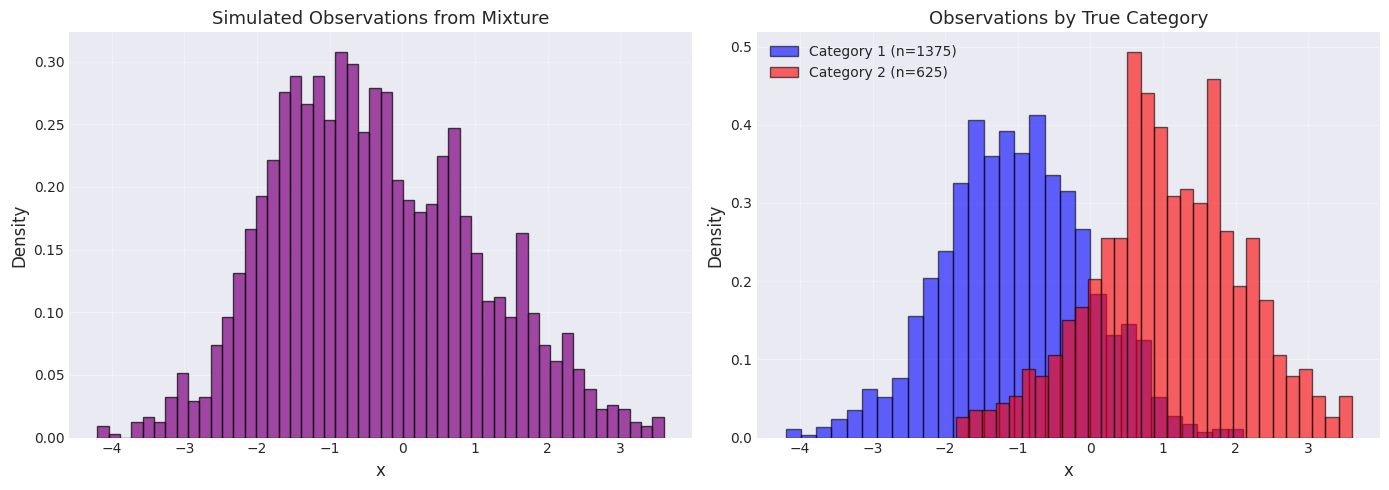


📊 Simulation Summary:
  Total samples: 2000
  Category 1: 1375 (68.8%)
  Category 2: 625 (31.2%)
  Overall mean: -0.38
  Category 1 mean: -1.02
  Category 2 mean: 1.05


In [9]:
@gen
def gaussian_mixture_model(theta, mu_1, mu_2, sigma_1, sigma_2):
    """
    Generative model for Gaussian mixture.
    
    Args:
        theta: Prior probability of category 1
        mu_1, mu_2: Means of categories 1 and 2
        sigma_1, sigma_2: Standard deviations of categories 1 and 2
    """
    # Sample category
    c = bernoulli(theta) @ "category"
    
    # Sample from both distributions (GenJAX needs these at top level)
    x1 = normal(mu_1, sigma_1) @ "observation_1"
    x2 = normal(mu_2, sigma_2) @ "observation_2"
    
    # Select which observation to use based on category
    x = lax.cond(c == 1, lambda _: x1, lambda _: x2, None)
    
    return x, c

# Simulate from mixture model
def simulate_mixture(theta=0.5, mu_1=-1.0, mu_2=1.0, sigma_1=1.0, sigma_2=1.0, n_samples=1000):
    """
    Simulate from Gaussian mixture model.
    """
    key = random.PRNGKey(42)
    
    observations = []
    categories = []
    
    for _ in range(n_samples):
        key, subkey = random.split(key)
        trace = gaussian_mixture_model.simulate(subkey, (theta, mu_1, mu_2, sigma_1, sigma_2))
        x, c = trace.get_retval()
        observations.append(float(x))
        categories.append(int(c))
    
    return np.array(observations), np.array(categories)

# Run simulation
print("Simulating from mixture model...")
obs, cats = simulate_mixture(theta=0.7, mu_1=-1.0, mu_2=1.0, sigma_1=1.0, sigma_2=1.0, n_samples=2000)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of all observations
axes[0].hist(obs, bins=50, density=True, alpha=0.7, edgecolor='black', color='purple')
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Simulated Observations from Mixture', fontsize=13)
axes[0].grid(True, alpha=0.3)

# Histogram by category
obs_c1 = obs[cats == 1]
obs_c2 = obs[cats == 0]
axes[1].hist(obs_c1, bins=30, density=True, alpha=0.6, edgecolor='black', color='blue', label=f'Category 1 (n={len(obs_c1)})')
axes[1].hist(obs_c2, bins=30, density=True, alpha=0.6, edgecolor='black', color='red', label=f'Category 2 (n={len(obs_c2)})')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Observations by True Category', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Simulation Summary:")
print(f"  Total samples: {len(obs)}")
print(f"  Category 1: {len(obs_c1)} ({len(obs_c1)/len(obs)*100:.1f}%)")
print(f"  Category 2: {len(obs_c2)} ({len(obs_c2)/len(obs)*100:.1f}%)")
print(f"  Overall mean: {np.mean(obs):.2f}")
print(f"  Category 1 mean: {np.mean(obs_c1):.2f}")
print(f"  Category 2 mean: {np.mean(obs_c2):.2f}")

## Summary

This notebook explored:

### Part 1: Gaussian-Gaussian Bayesian Update
- **Likelihood variance** effect: Smaller σ²_x → sharper posterior (data more influential)
- **Number of observations** effect: More data → narrower posterior (less uncertainty)
- **Sequential learning**: Posterior converges to sample mean as n → ∞
- **Predictive distribution**: Has larger variance than posterior (adds data uncertainty)

### Part 2: Gaussian Mixture Models
- **Prior θ** effect: Shifts decision boundary, acts as "magnifier" for one component
- **Variance ratio** effect: Component with larger variance dominates tails
- **Marginal distribution**: Weighted sum of components, can be bimodal or unimodal
- **Decision boundary**: Where P(c=1|x) = 0.5, depends on both θ and variance ratios

### GenJAX Implementation
- Analytical updates for conjugate priors
- Simulation-based approaches for verification
- Full generative models for mixture distributions

---

**Next Steps**: Apply these concepts to the assignment problems!